<a href="https://colab.research.google.com/github/kmrasmussen/cell_project/blob/main/Section_4_1_VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Much of the code from this notebook is from
https://pyro.ai/examples/vae.html

In [1]:
!pip install pyro-ppl

     |████████████████████████████████| 614kB 2.8MB/s 


In [2]:
import os
import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

import matplotlib.pyplot as plt

In [3]:
assert pyro.__version__.startswith('1.4.0')
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

AssertionError: ignored

In [ ]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = dset.MNIST(root=root, train=True, transform=trans,
                           download=download)
    test_set = dset.MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader, train_set, test_set

In [ ]:
# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale


# define the PyTorch module that parameterizes the
# observation likelihood p(x|z)
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = torch.sigmoid(self.fc21(hidden))
        return loc_img


In [ ]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [ ]:
def train(svi, train_loader, use_cuda = False):
  epoch_loss = 0.
  for x, _ in train_loader:
    if use_cuda:
      x = x.cuda()
    epoch_loss += svi.step(x)
  
  normalizer_train = len(train_loader.dataset)
  total_epoch_loss = epoch_loss / normalizer_train
  return total_epoch_loss

In [ ]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [ ]:

# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False

# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 20
TEST_FREQUENCY = 5

In [ ]:
train_loader, test_loader, train_set, test_set = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 190.9630
[epoch 000] average test loss: 155.7649
[epoch 001]  average training loss: 146.2289
[epoch 002]  average training loss: 132.9159
[epoch 003]  average training loss: 124.6936
[epoch 004]  average training loss: 119.5353
[epoch 005]  average training loss: 115.9922
[epoch 005] average test loss: 113.8192
[epoch 006]  average training loss: 113.7288
[epoch 007]  average training loss: 112.1366
[epoch 008]  average training loss: 110.9583
[epoch 009]  average training loss: 109.9786
[epoch 010]  average training loss: 109.2058
[epoch 010] average test loss: 108.3574
[epoch 011]  average training loss: 108.5663
[epoch 012]  average training loss: 108.0132
[epoch 013]  average training loss: 107.5486
[epoch 014]  average training loss: 107.0921
[epoch 015]  average training loss: 106.7289
[epoch 015] average test loss: 106.0388
[epoch 016]  average training loss: 106.3730
[epoch 017]  average training loss: 106.1228
[epoch 018]  average training 

Text(0, 0.5, 'ELBO')

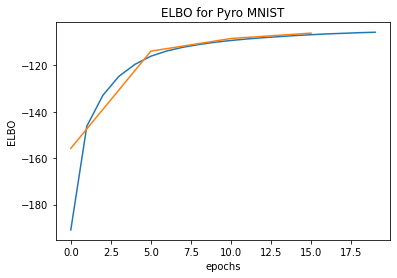

In [ ]:
plt.plot(train_elbo, label = 'train')
plt.plot(np.arange(0, 20, 5),test_elbo, label='validation')
plt.title('ELBO for Pyro MNIST')
plt.xlabel('epochs')
plt.ylabel('ELBO')

In [ ]:
train_loader, test_loader = setup_data_loaders(batch_size=3, use_cuda=USE_CUDA)
i = 0

real_images = []
reconstructed_images = []

for x, other in test_loader:
  if i > 4:
    break
  # if on GPU put mini-batch into CUDA memory
  if USE_CUDA:
      x = x.cuda()
  np_img = x[0][0].numpy()
  real_images.append(np_img)

  recons_x = vae.reconstruct_img(x)
  recons_img = recons_x[0].reshape(28,28).detach().numpy()
  reconstructed_images.append(recons_img)

  



  i += 1

ValueError: ignored

In [ ]:
len(reconstructed_images)

5

In [ ]:
len(real_images)

5

<Figure size 144x360 with 0 Axes>

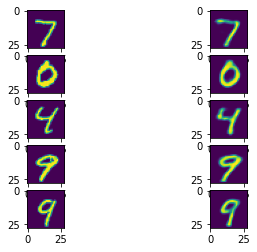

In [ ]:
f, axarr = plt.subplots(len(real_images),2)
for i in range(len(real_images)):
  axarr[i,0].imshow(real_images[i])
  axarr[i,1].imshow(reconstructed_images[i])

In [ ]:
torch.save(vae, '/content/pyro_mnist1.pkl')

In [ ]:
vae = torch.load('/content/pyro_mnist1.pkl')

In [ ]:
embedding_batch_list = []
batch_labels = []

for i, data in enumerate(test_loader):
  images, labels = data
  #print(images.shape)
  #print(labels.shape)
  embedding_means, embedding_vars = vae.encoder.forward(images)
  #print(embedding_means.shape)
  embedding_batch_list.append(embedding_means)
  batch_labels.append(labels)


In [ ]:
len(embedding_batch_list)

40

In [ ]:
test_set_encoded = torch.stack(embedding_batch_list[0:-1], dim=0).reshape(-1,50).detach().numpy()

In [ ]:
test_set_labels = torch.stack(batch_labels[0:-1]).reshape(-1).numpy()

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP()

In [ ]:
test_set_encoded_umap = reducer.fit_transform(test_set_encoded)

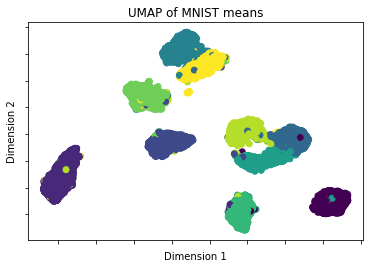

In [ ]:
fig, ax = plt.subplots()
plt.scatter(test_set_encoded_umap[:,0], test_set_encoded_umap[:,1], c=test_set_labels)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.title('UMAP of MNIST means')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.savefig('/content/mnist_umap.png')

In [ ]:
reducer = umap.UMAP()


In [ ]:
embedding_batch_list = []
batch_labels = []
for i, data in enumerate(test_loader):
  images, labels = data
  #print(images.shape)
  #print(labels.shape)
  #embedding_means, embedding_vars = vae.encoder.forward(images)
  #print(embedding_means.shape)
  embedding_batch_list.append(images)
  batch_labels.append(labels)

In [ ]:
image_vectors = torch.stack(embedding_batch_list[:-1]).reshape(-1,784)

In [ ]:
image_vectors_umap = reducer.fit_transform(image_vectors)

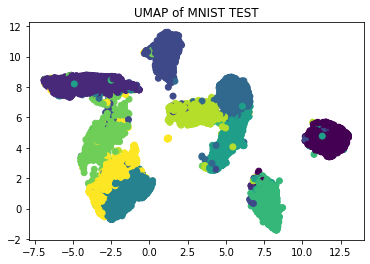

In [ ]:
plt.title('UMAP of MNIST TEST')
plt.scatter(image_vectors_umap[:,0], image_vectors_umap[:,1], c=test_set_labels)
plt.savefig('/content/exp.3.1.umap_of_mnist_test.png')